In [1]:
import numpy as np 
import matplotlib.pyplot as plt 
from scipy.stats import truncnorm
from sklearn.metrics import roc_curve, auc

def make_ref_data(nevents,scale,mean):
    #first: the pTs
    # this gets a uniform sampling of the surface of a 9d hypersphere
    # see https://mathworld.wolfram.com/HyperspherePointPicking.html
    ndim= 10
    pT=np.random.normal(size=(nevents,ndim))
    pT=pT/np.sqrt(np.sum(pT**2,axis=-1).reshape((-1,1))) 
    # take the positive quadrant
    pT=np.abs(pT)
    # rescale by m sampled from (truncated) gaussian
    m=np.empty((0))
    while(len(m)<len(pT)):
        temptemp=scale*np.random.normal(size=(10000))+mean
        m=np.concatenate((m,temptemp[(temptemp>0)]))
    m=m[:len(pT)]
    pT=pT*(m.reshape((-1,1)))    

    # then the etas
    eta=np.random.normal(size=(nevents,ndim))*(1+pT*0.5)

    refdata=np.dstack((pT,eta))

    return refdata

sigscale=0.3
sigmean=1

bgscale=0.3
bgmean=0.5
n_events= 200000
sigdata = make_ref_data(n_events, sigscale, sigmean)
bgdata = make_ref_data(n_events, bgscale, bgmean)

In [2]:
sigdata_digit_x = np.digitize(sigdata[...,0], bins=np.linspace(0,2,30))
sigdata_digit_y = np.digitize(sigdata[...,1], bins=np.linspace(-7,7,30))
bgdata_digit_x = np.digitize(bgdata[...,0], bins=np.linspace(0,2,30))
bgdata_digit_y = np.digitize(bgdata[...,1], bins=np.linspace(-7,7,30))

sigdata_digit = np.stack((sigdata_digit_x, sigdata_digit_y), axis=-1)
bgdata_digit = np.stack((bgdata_digit_x, bgdata_digit_y), axis=-1)

# order by [...,0]

In [3]:
sigdata_digit[0]

array([[10, 16],
       [ 5, 16],
       [ 5, 14],
       [ 2, 16],
       [10, 20],
       [ 2, 16],
       [ 2, 14],
       [ 6, 14],
       [21, 11],
       [ 9, 15]])

In [4]:

idx = np.argsort(-sigdata_digit[..., 0], axis=1)
sigdata_digit = np.take_along_axis(sigdata_digit, idx[:,:,None], axis=1)

In [14]:
def bins_to_seq_encoding( x: np.ndarray) -> np.ndarray:
    # combine 3D bins into flat token IDs
    a = x[..., 0]
    b = x[..., 1]
    return (a * 30 + b)

sigdata_seq = bins_to_seq_encoding(sigdata_digit)
bgdata_seq = bins_to_seq_encoding(bgdata_digit)

In [22]:
import numpy as np
from scipy.special import erf, gamma
import math

def logp_ref(data,scale,mean):
    ndim=10
    r=np.sqrt(np.sum(data[:,:,0]**2,axis=-1))
    logp_r=-(r-mean)**2/(2*scale**2)\
                    -np.log(np.sqrt(np.pi*scale**2/2))-np.log(1+erf(mean/scale/np.sqrt(2)))
    logp_r-=(ndim-1)*np.log(r)
    logp=logp_r-np.log(2*np.pi**(ndim/2)/gamma(ndim/2)/2**ndim) # #-logp_phi
    logpeta=np.sum(-0.5*data[:,:,1]**2/(1+0.5*data[:,:,0])**2-np.log(np.sqrt(2*np.pi*(1+0.5*data[:,:,0])**2)),axis=-1)
    logp+=logpeta
    return logp


sig_ll_sigmodel = logp_ref(sigdata, sigmean, sigscale)
bg_ll_sigmodel = logp_ref(bgdata, sigmean, sigscale)

sig_ll_bgmodel = logp_ref(sigdata, bgmean, bgscale)
bg_ll_bgmodel = logp_ref(bgdata, bgmean, bgscale)

/tmp/ipykernel_1382720/1850936514.py:36: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr, 1/fpr, label=f'Ref true, AUC={roc_auc:.3f},\nR30={r30:.1f}')


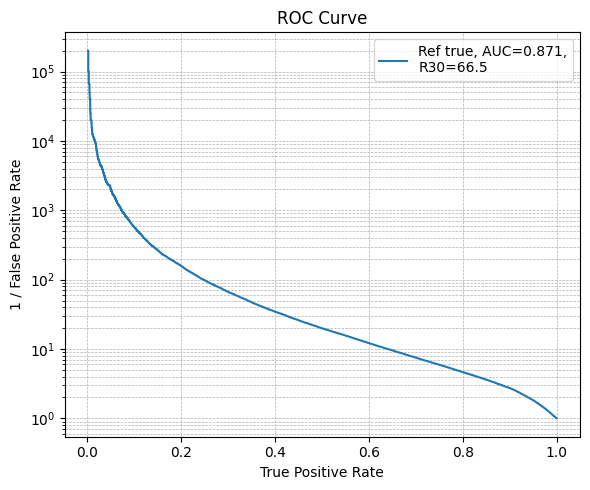

In [23]:
# from sklearn.metrics import roc_curve, auc
# import matplotlib.pyplot as plt
# import numpy as np

# ------------------------
# Prepare labels and scores
# ------------------------
labels = np.concatenate([np.ones_like(sig_ll_sigmodel), np.zeros_like(bg_ll_sigmodel)])

# Use log-likelihood ratio as discriminant
llr_signal = sig_ll_sigmodel - sig_ll_bgmodel
llr_background = bg_ll_sigmodel - bg_ll_bgmodel
llr_scores = np.concatenate([llr_signal, llr_background])

# ------------------------
# Compute ROC
# ------------------------
fpr, tpr, _ = roc_curve(labels, llr_scores)
roc_auc = auc(fpr, tpr)

# ------------------------
# Compute R30 and R50
# ------------------------
def interp_rejection_at_tpr(target_tpr, tpr, fpr):
    if target_tpr < tpr[0] or target_tpr > tpr[-1]:
        return np.nan
    return 1 / np.interp(target_tpr, tpr, fpr)

r30 = interp_rejection_at_tpr(0.30, tpr, fpr)
r50 = interp_rejection_at_tpr(0.50, tpr, fpr)

# ------------------------
# Plot ROC with 1/FPR and annotated R-values
# ------------------------
plt.figure(figsize=(6, 5))
plt.plot(tpr, 1/fpr, label=f'Ref true, AUC={roc_auc:.3f},\nR30={r30:.1f}')

plt.xlabel('True Positive Rate')
plt.ylabel('1 / False Positive Rate')
plt.yscale('log')
plt.title('ROC Curve')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.legend()
plt.tight_layout()
plt.show()


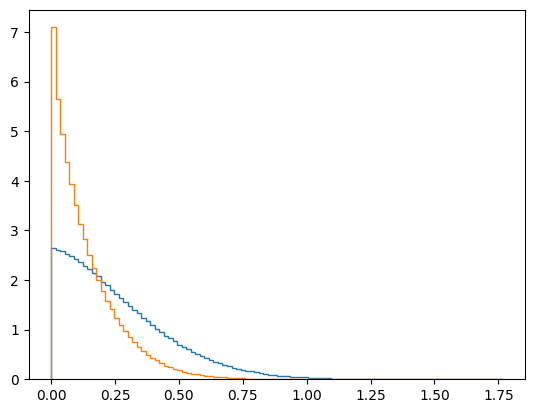

In [15]:
_,bins,_ = plt.hist(sigdata[:,:,0].flatten(),bins=100,density=True,histtype='step')
_ = plt.hist(bgdata[:,:,0].flatten(),bins=bins,density=True,histtype='step')

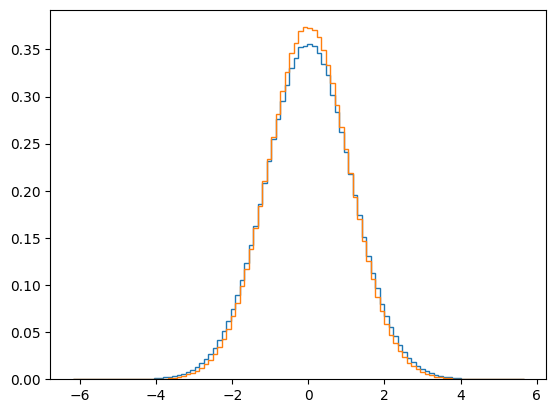

In [ ]:
_,bins,_ = plt.hist(sigdata[:,:,1].flatten(),bins=100,density=True,histtype='step')
_ = plt.hist(bgdata[:,:,1].flatten(),bins=bins,density=True,histtype='step')

In [ ]:
preproc_pt_mean = np.concatenate(np.log([bgdata[:,:,0],sigdata[:,:,0]])).mean()
preproc_pt_std = np.concatenate(np.log([bgdata[:,:,0],sigdata[:,:,0]])).std()

preproc_eta_mean = np.concatenate([bgdata[:,:,1],sigdata[:,:,1]]).mean()
preproc_eta_std = np.concatenate([bgdata[:,:,1],sigdata[:,:,1]]).std()

print("pt mean: ",preproc_pt_mean)
print("pt std: ",preproc_pt_std)
print("eta mean: ",preproc_eta_mean)
print("eta std: ",preproc_eta_std)

pt mean:  -2.173596811742521
pt std:  1.2937464746136649
eta mean:  0.00036626372231370215
eta std:  1.1025602142150686


In [ ]:
preproc_sigpt = (np.log(sigdata[:,:,0])-preproc_pt_mean)/preproc_pt_std
preproc_bgpt = (np.log(bgdata[:,:,0])-preproc_pt_mean)/preproc_pt_std

preproc_sigeta = (sigdata[:,:,1]-preproc_eta_mean)/preproc_eta_std
preproc_bgeta = (bgdata[:,:,1]-preproc_eta_mean)/preproc_eta_std

preproc_sigdata = np.stack([preproc_sigpt,preproc_sigeta],-1)
preproc_bgdata = np.stack([preproc_bgpt,preproc_bgeta],-1)

In [ ]:
import torch
from torch.utils.data import TensorDataset, DataLoader, random_split

# ------------------------
# Step 1: Convert to torch tensors
# ------------------------
sig_tensor = torch.tensor(preproc_sigdata, dtype=torch.float32)  # shape: (N_sig, 10, 2)
bg_tensor = torch.tensor(preproc_bgdata, dtype=torch.float32)    # shape: (N_bg, 10, 2)

# ------------------------
# Step 2: Create Datasets (no labels needed for unsupervised CFM)
# ------------------------
sig_dataset = TensorDataset(sig_tensor)
bg_dataset = TensorDataset(bg_tensor)

# ------------------------
# Step 3: Split each into train/val sets
# ------------------------
val_frac = 0.2
sig_val_size = int(val_frac * len(sig_dataset))
bg_val_size = int(val_frac * len(bg_dataset))

sig_train_size = len(sig_dataset) - sig_val_size
bg_train_size = len(bg_dataset) - bg_val_size

sig_train_dataset, sig_val_dataset = random_split(sig_dataset, [sig_train_size, sig_val_size])
bg_train_dataset, bg_val_dataset = random_split(bg_dataset, [bg_train_size, bg_val_size])

# ------------------------
# Step 4: Build Dataloaders
# ------------------------
batch_size = 512

sig_dataloader = DataLoader(sig_train_dataset, batch_size=batch_size, shuffle=True)
sig_val_dataloader = DataLoader(sig_val_dataset, batch_size=batch_size, shuffle=False)

bg_dataloader = DataLoader(bg_train_dataset, batch_size=batch_size, shuffle=True)
bg_val_dataloader = DataLoader(bg_val_dataset, batch_size=batch_size, shuffle=False)


In [ ]:
import torch
from tqdm import tqdm
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.utils.weight_norm as weight_norm
import numpy as np
import math
from torchcfm.optimal_transport import OTPlanSampler
from torchdyn.core import NeuralODE
from torch.utils.data import DataLoader

# --- MASKING UTILITIES ---
def create_mask(batch):
    return (batch.abs().sum(dim=-1) > 0).float()

def get_multiplicity_distribution(dataset):
    counts = (dataset[:, :, 0] != 0).sum(axis=1)
    unique, freqs = np.unique(counts, return_counts=True)
    prob = freqs / freqs.sum()
    return unique, prob

# --- TIME EMBEDDING ---
def timestep_sinusoidal_embedding(timesteps, dim, max_period=10000):
    half = dim // 2
    freqs = torch.exp(-math.log(max_period) * torch.arange(start=0, end=half, dtype=torch.float32, device=timesteps.device) / half)
    args = timesteps[:, None].float() * freqs[None]
    embedding = torch.cat([torch.cos(args), torch.sin(args)], dim=-1)
    if dim % 2:
        embedding = torch.cat([embedding, torch.zeros_like(embedding[:, :1])], dim=-1)
    return embedding

class EPiC_layer(nn.Module):
    def __init__(self, local_in_dim, hid_dim, latent_dim, context_dim):
        super(EPiC_layer, self).__init__()
        self.fc_global1 = weight_norm(nn.Linear(2 * hid_dim + latent_dim, hid_dim)) 
        self.fc_global2 = weight_norm(nn.Linear(hid_dim, latent_dim)) 
        self.fc_local1 = weight_norm(nn.Linear(local_in_dim + latent_dim + context_dim, hid_dim))
        self.fc_local2 = weight_norm(nn.Linear(hid_dim, hid_dim))

    def forward(self, x_global, x_local, context, mask):
        """
        Args:
            x_global: (batch, latent_dim)
            x_local:  (batch, num_points, hid_dim)
            context:  (batch, num_points, context_dim)
            mask:     (batch, num_points, 1) — float or bool mask
        Returns:
            x_global, x_local: updated latent/global features
        """
        # --- Mask-aware pooling ---
        masked_local = x_local * mask  # (B, N, D)
        sum_pool = masked_local.sum(1)  # (B, D)
        count = mask.sum(1).clamp(min=1e-6)  # (B, 1)
        mean_pool = sum_pool / count  # (B, D)

        # --- Global update ---
        x_pooledCATglobal = torch.cat([mean_pool, sum_pool*0.1, x_global], dim=1)  # (B, 2*D + latent)
        x_global1 = F.leaky_relu(self.fc_global1(x_pooledCATglobal))
        x_global = F.leaky_relu(self.fc_global2(x_global1) + x_global)

        # --- Local update ---
        B, N, _ = x_local.shape
        x_global2local = x_global.unsqueeze(1).expand(-1, N, -1)  # (B, N, latent)
        x_localCATglobal = torch.cat([x_local, x_global2local, context], dim=-1)  # (B, N, D+latent+context)
        x_local1 = F.leaky_relu(self.fc_local1(x_localCATglobal))
        x_local = F.leaky_relu(self.fc_local2(x_local1) + x_local)

        return x_global, x_local


class EPiC_Projection(nn.Module):
    def __init__(self, dim_latent_global, latent_local, dim_hidden):
        super(EPiC_Projection, self).__init__()
        self.local_0 = weight_norm(nn.Linear(latent_local, dim_hidden))
        self.global_0 = weight_norm(nn.Linear(2 * dim_hidden, dim_hidden))
        self.global_1 = weight_norm(nn.Linear(dim_hidden, dim_hidden))
        self.global_2 = weight_norm(nn.Linear(dim_hidden, dim_latent_global))

    def meansum_pooling(self, x_local, mask):
        mask = mask.float()
        masked_x = x_local * mask
        sum_pool = masked_x.sum(1)
        count = mask.sum(1).clamp(min=1e-6)
        mean_pool = sum_pool / count
        return torch.cat([mean_pool, sum_pool*0.1], dim=-1)

    def forward(self, x_local, mask):
        x_local = F.leaky_relu(self.local_0(x_local.float()))
        x_global = self.meansum_pooling(x_local, mask)
        x_global = F.leaky_relu(self.global_0(x_global))
        x_global = F.leaky_relu(self.global_1(x_global))
        x_global = F.leaky_relu(self.global_2(x_global))
        return x_global, x_local

class EPiC_Network(nn.Module):
    def __init__(self, dim_features=2, dim_latent_global=16, time_embedding='sinusoidal', dim_time_embedding=16, dim_hidden=128, num_layers=4, skip_connection=True):
        super(EPiC_Network, self).__init__()
        self.time_embedding = time_embedding
        self.dim_time_embedding = dim_time_embedding
        self.num_layers = num_layers
        self.skip_connection = skip_connection
        self.epic_proj = EPiC_Projection(dim_latent_global, dim_features + dim_time_embedding, dim_hidden)
        self.epic_layers = nn.ModuleList([
            EPiC_layer(local_in_dim=dim_hidden, hid_dim=dim_hidden, latent_dim=dim_latent_global, context_dim=dim_time_embedding)
            for _ in range(num_layers)
        ])
        self.output = weight_norm(nn.Linear(dim_hidden, dim_features))

    def forward(self, t, x, mask=None):
        if mask is None:
            mask = (x.abs().sum(dim=-1) > 0).float()
        mask = mask.unsqueeze(-1)

        # Time embedding
        if t.dim() == 2 and t.shape[1] == 1:
            t = t.squeeze(1)
        t_emb = timestep_sinusoidal_embedding(t, self.dim_time_embedding)
        t_rep = t_emb.unsqueeze(1).expand(-1, x.shape[1], -1)
    
        x_local = torch.cat([x, t_rep], dim=-1) * mask

        x_global, x_local = self.epic_proj(x_local, mask)

        if self.skip_connection:
            x_global_skip = x_global.clone()
            x_local_skip = x_local.clone()

        # EPiC blocks with proper masked layer call
        for layer in self.epic_layers:
            x_global, x_local = layer(x_global, x_local * mask, t_rep * mask, mask)
            if self.skip_connection:
                x_global += x_global_skip
                x_local = (x_local + x_local_skip) * mask  # ensure masking is reapplied

        return self.output(x_local) * mask


In [ ]:
import torch
from tqdm import tqdm
import numpy as np

# ------------------------
# Helper functions
# ------------------------
def sample_noise_like(x):
    return torch.randn_like(x)

def sample_xt(x0, x1, t, eps):
    t = t[:, None, None]  # reshape to (B, 1, 1)
    return x0 + t * (x1 - x0) + eps * t * (1 - t)

def compute_conditional_flow(x0, x1, t, xt):
    del t, xt  # not used
    return x1 - x0

def sample_location_and_conditional_flow(x0, x1, t=None):
    if t is None:
        t = torch.rand(x0.shape[0]).type_as(x0)  # shape (B,)
    eps = sample_noise_like(x0)
    xt = sample_xt(x0, x1, t, eps)
    ut = compute_conditional_flow(x0, x1, t, xt)
    return t[:, None], xt, ut  # t reshaped to (B, 1)

# ------------------------
# Training config
# ------------------------
device = 'cuda' if torch.cuda.is_available() else 'cpu'
signal_model = EPiC_Network().to(device)
optimizer_sig = torch.optim.Adam(signal_model.parameters(), lr=1e-4)
scheduler_sig = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer_sig, patience=10, factor=0.1)

min_val_loss_sig = float('inf')
patience_sig = 50
num_epochs = 300

for epoch in range(num_epochs):
    signal_model.train()
    train_loss = 0.0

    for (x1,) in sig_dataloader:
        x1 = x1.to(device)
        x0 = torch.randn_like(x1).to(device)

        t, xt, ut = sample_location_and_conditional_flow(x0, x1)
        mask = create_mask(x1).to(device)

        vt = signal_model(t=t, x=xt, mask=mask)
        loss = torch.mean((vt - ut) ** 2)

        loss.backward()
        optimizer_sig.step()
        optimizer_sig.zero_grad()
        train_loss += loss.item() / len(sig_dataloader)

    signal_model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for (x1,) in sig_val_dataloader:
            x1 = x1.to(device)
            x0 = torch.randn_like(x1).to(device)

            t, xt, ut = sample_location_and_conditional_flow(x0, x1)
            mask = create_mask(x1).to(device)

            vt = signal_model(t=t, x=xt, mask=mask)
            loss = torch.mean((vt - ut) ** 2)
            val_loss += loss.item() / len(sig_val_dataloader)

    scheduler_sig.step(val_loss)
    print(f"[Signal] Epoch {epoch+1}: Train Loss = {train_loss:.4f}, Val Loss = {val_loss:.4f}")

    if val_loss < min_val_loss_sig:
        min_val_loss_sig = val_loss
        patience_sig = 50
        torch.save(signal_model.state_dict(), "checkpoints/epic_signal_model.pth")
        print("✅ Signal model saved!")
    else:
        patience_sig -= 1

    if patience_sig == 0:
        print("⛔ Early stopping: signal model")
        break


/home/yp325/miniconda3/envs/torchcfm/lib/python3.10/site-packages/torch/nn/utils/weight_norm.py:143: FutureWarning: `torch.nn.utils.weight_norm` is deprecated in favor of `torch.nn.utils.parametrizations.weight_norm`.
  WeightNorm.apply(module, name, dim)


[Signal] Epoch 1: Train Loss = 1.6986, Val Loss = 1.4849
✅ Signal model saved!
[Signal] Epoch 2: Train Loss = 1.4832, Val Loss = 1.4808
✅ Signal model saved!
[Signal] Epoch 3: Train Loss = 1.4825, Val Loss = 1.4779
✅ Signal model saved!
[Signal] Epoch 4: Train Loss = 1.4820, Val Loss = 1.4800
[Signal] Epoch 5: Train Loss = 1.4819, Val Loss = 1.4732
✅ Signal model saved!
[Signal] Epoch 6: Train Loss = 1.4792, Val Loss = 1.4781
[Signal] Epoch 7: Train Loss = 1.4791, Val Loss = 1.4758
[Signal] Epoch 8: Train Loss = 1.4801, Val Loss = 1.4784
[Signal] Epoch 9: Train Loss = 1.4788, Val Loss = 1.4793
[Signal] Epoch 10: Train Loss = 1.4781, Val Loss = 1.4762
[Signal] Epoch 11: Train Loss = 1.4782, Val Loss = 1.4838
[Signal] Epoch 12: Train Loss = 1.4813, Val Loss = 1.4802
[Signal] Epoch 13: Train Loss = 1.4798, Val Loss = 1.4793
[Signal] Epoch 14: Train Loss = 1.4804, Val Loss = 1.4818
[Signal] Epoch 15: Train Loss = 1.4791, Val Loss = 1.4748
[Signal] Epoch 16: Train Loss = 1.4774, Val Loss = 

In [ ]:
class TorchdynWrapper(torch.nn.Module):
    """ Wraps model to torchdyn compatible format.
    """
    def __init__(self, net):
        super().__init__()
        self.nn = net
    def forward(self, t, x, **kwargs):
        # t = t.repeat(x.shape[:-1]+(1,), 1)
        t = t.repeat(x.shape[0])[:, None]
        return self.nn(t=t, x=x)

In [ ]:
from torchdyn.core import NeuralODE
import numpy as np
import torch

# Instantiate model architectures
signal_model = EPiC_Network().to(device)

# Load trained weights
signal_model.load_state_dict(torch.load("checkpoints/epic_signal_model.pth"))

signal_model.eval()

# Use your trained model here (e.g., signal_model or background_model)
wrapped_model = TorchdynWrapper(signal_model.to(device))  # or background_model
node = NeuralODE(wrapped_model, solver='euler').to(device)

# Sample from base distribution
noise_full = torch.randn([100000, 10, 2])  # shape: (100k, 10, 2)

inp = []
out = []

with torch.no_grad():
    for i in range(10):
        print(f"Iteration {i+1}/10")
        batch_noise = noise_full[i*10000:(i+1)*10000].to(device)  # (10k, 10, 2)
        traj = node.trajectory(x=batch_noise, t_span=torch.linspace(0, 1, 300).to(device))  # (1000, 10k, 10, 2)

        inp_temp = traj[0].cpu().numpy()   # x(t=0)
        out_temp = traj[-1].cpu().numpy()  # x(t=1)

        if i == 0:
            inp = inp_temp
            out = out_temp
        else:
            inp = np.concatenate((inp, inp_temp), axis=0)
            out = np.concatenate((out, out_temp), axis=0)
            
gen_sigpt = np.exp(out[:,:,0]*preproc_pt_std+preproc_pt_mean)
gen_sigeta = out[:,:,1]*preproc_eta_std+preproc_eta_mean

gen_sigdata = np.stack([gen_sigpt,gen_sigeta],-1)

np.save("generated/gen_sigdata",gen_sigdata)

Iteration 1/10


/tmp/ipykernel_1047333/3070058034.py:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  signal_model.load_state_dict(torch.load("checkpoints/epic_signal_model.pth"))


Iteration 2/10
Iteration 3/10
Iteration 4/10
Iteration 5/10
Iteration 6/10
Iteration 7/10
Iteration 8/10
Iteration 9/10
Iteration 10/10


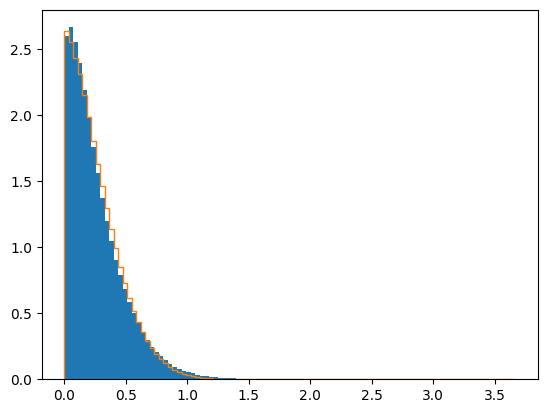

In [ ]:
_,bins,_ = plt.hist((gen_sigdata[:,:,0]).flatten(),bins=100,density=True)
_ = plt.hist(sigdata[:,:,0].flatten(),bins=bins,density=True,histtype='step')


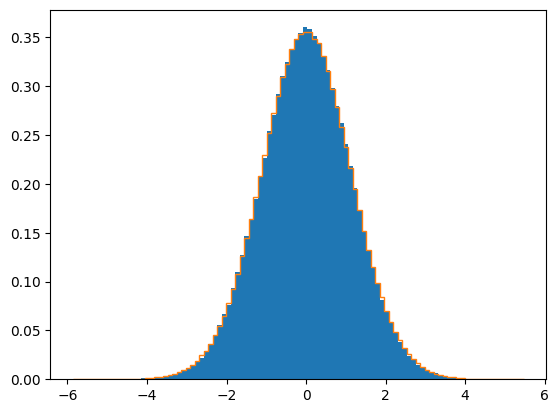

In [ ]:
_,bins,_ = plt.hist((gen_sigdata[:,:,1]).flatten(),bins=100,density=True)
_ = plt.hist(sigdata[:,:,1].flatten(),bins=bins,density=True,histtype='step')

In [ ]:
background_model = EPiC_Network().to(device)
optimizer_bg = torch.optim.Adam(background_model.parameters(), lr=1e-4)
scheduler_bg = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer_bg, patience=10, factor=0.1)

min_val_loss_bg = float('inf')
patience_bg = 50

for epoch in range(num_epochs):
    background_model.train()
    train_loss = 0.0

    for (x1,) in bg_dataloader:
        x1 = x1.to(device)
        x0 = torch.randn_like(x1).to(device)

        t, xt, ut = sample_location_and_conditional_flow(x0, x1)
        mask = create_mask(x1).to(device)

        vt = background_model(t=t, x=xt, mask=mask)
        loss = torch.mean((vt - ut) ** 2)

        loss.backward()
        optimizer_bg.step()
        optimizer_bg.zero_grad()
        train_loss += loss.item() / len(bg_dataloader)

    background_model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for (x1,) in bg_val_dataloader:
            x1 = x1.to(device)
            x0 = torch.randn_like(x1).to(device)

            t, xt, ut = sample_location_and_conditional_flow(x0, x1)
            mask = create_mask(x1).to(device)

            vt = background_model(t=t, x=xt, mask=mask)
            loss = torch.mean((vt - ut) ** 2)
            val_loss += loss.item() / len(bg_val_dataloader)

    scheduler_bg.step(val_loss)
    print(f"[Background] Epoch {epoch+1}: Train Loss = {train_loss:.4f}, Val Loss = {val_loss:.4f}")

    if val_loss < min_val_loss_bg:
        min_val_loss_bg = val_loss
        patience_bg = 50
        torch.save(background_model.state_dict(), "checkpoints/epic_background_model.pth")
        print("✅ Background model saved!")
    else:
        patience_bg -= 1

    if patience_bg == 0:
        print("⛔ Early stopping: background model")
        break


[Background] Epoch 1: Train Loss = 1.6626, Val Loss = 1.5115
✅ Background model saved!
[Background] Epoch 2: Train Loss = 1.5058, Val Loss = 1.5022
✅ Background model saved!
[Background] Epoch 3: Train Loss = 1.5019, Val Loss = 1.5088
[Background] Epoch 4: Train Loss = 1.5006, Val Loss = 1.5038
[Background] Epoch 5: Train Loss = 1.4979, Val Loss = 1.4995
✅ Background model saved!
[Background] Epoch 6: Train Loss = 1.4987, Val Loss = 1.4988
✅ Background model saved!
[Background] Epoch 7: Train Loss = 1.4976, Val Loss = 1.4978
✅ Background model saved!
[Background] Epoch 8: Train Loss = 1.4973, Val Loss = 1.5006
[Background] Epoch 9: Train Loss = 1.4998, Val Loss = 1.4997
[Background] Epoch 10: Train Loss = 1.4973, Val Loss = 1.4969
✅ Background model saved!
[Background] Epoch 11: Train Loss = 1.4958, Val Loss = 1.5040
[Background] Epoch 12: Train Loss = 1.4988, Val Loss = 1.4986
[Background] Epoch 13: Train Loss = 1.5006, Val Loss = 1.4982
[Background] Epoch 14: Train Loss = 1.4950, Val

In [ ]:
from torchdyn.core import NeuralODE
import numpy as np
import torch

# Instantiate model architectures
background_model = EPiC_Network().to(device)

# Load trained weights
background_model.load_state_dict(torch.load("checkpoints/epic_background_model.pth"))

background_model.eval()

# Use your trained model here (e.g., signal_model or background_model)
wrapped_model = TorchdynWrapper(background_model.to(device))  # or background_model
node = NeuralODE(wrapped_model, solver='euler').to(device)

# Sample from base distribution
noise_full = torch.randn([100000, 10, 2])  # shape: (100k, 10, 2)

inp = []
out = []

with torch.no_grad():
    for i in range(10):
        print(f"Iteration {i+1}/10")
        batch_noise = noise_full[i*10000:(i+1)*10000].to(device)  # (10k, 10, 2)
        traj = node.trajectory(x=batch_noise, t_span=torch.linspace(0, 1, 300).to(device))  # (1000, 10k, 10, 2)

        inp_temp = traj[0].cpu().numpy()   # x(t=0)
        out_temp = traj[-1].cpu().numpy()  # x(t=1)

        if i == 0:
            inp = inp_temp
            out = out_temp
        else:
            inp = np.concatenate((inp, inp_temp), axis=0)
            out = np.concatenate((out, out_temp), axis=0)
            
gen_bgpt = np.exp(out[:,:,0]*preproc_pt_std+preproc_pt_mean)
gen_bgeta = out[:,:,1]*preproc_eta_std+preproc_eta_mean

gen_bgdata = np.stack([gen_bgpt,gen_bgeta],-1)

np.save("generated/gen_bgdata",gen_bgdata)

Iteration 1/10


/tmp/ipykernel_1047333/2872467842.py:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  background_model.load_state_dict(torch.load("checkpoints/epic_background_model.pth"))


Iteration 2/10
Iteration 3/10
Iteration 4/10
Iteration 5/10
Iteration 6/10
Iteration 7/10
Iteration 8/10
Iteration 9/10
Iteration 10/10


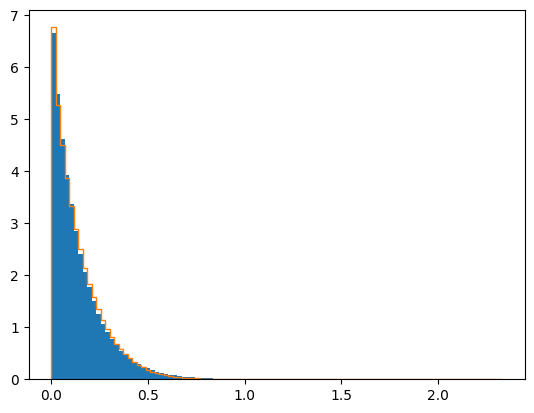

In [ ]:
_,bins,_ = plt.hist((gen_bgdata[:,:,0]).flatten(),bins=100,density=True)
_ = plt.hist(bgdata[:,:,0].flatten(),bins=bins,density=True,histtype='step')

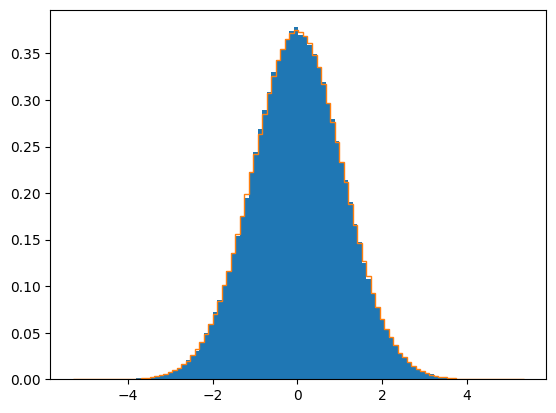

In [ ]:
_,bins,_ = plt.hist((gen_bgdata[:,:,1]).flatten(),bins=100,density=True)
_ = plt.hist(bgdata[:,:,1].flatten(),bins=bins,density=True,histtype='step')